# Hot water heater case study
> Energy and emissions comparisons using Jupyter notebooks.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png
- author: Ryan Fobel
- categories: [climate, jupyter]

[![slides](https://github.com/ryanfobel/utility-bill-scraper/blob/main/notebooks/features/png/case_study_slides.png?raw=1)](https://docs.google.com/presentation/d/1T2BWuNzWcMmAfEirpQaY1A9PR68Hk0o_NS-OT0H56q8/edit?usp=sharing)

Open an interactive version of this notebook by clicking on this button: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanfobel/utility-bill-scraper/blob/main/notebooks%2Ffeatures%2Fcase_study.ipynb)

In [21]:
%load_ext autoreload
%autoreload 2

try:
    import utility_bill_scraper
except ModuleNotFoundError:
    import subprocess
    import sys

    cmd = (
        f"{sys.executable} -m pip install --upgrade --upgrade-strategy "
        "only-if-needed "
        "git+https://github.com/ryanfobel/utility-bill-scraper.git"
    )
    subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True).decode("utf-8")

%matplotlib inline

import datetime as dt
import os
import sys

import arrow
from cycler import cycler
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utility_bill_scraper import LIGHT_COLORMAP
import utility_bill_scraper.canada.on.kitchener_wilmot_hydro as kwh
import utility_bill_scraper.canada.on.kitchener_utilities as ku
from utility_bill_scraper import GAS_KGCO2_PER_CUBIC_METER, GAS_KWH_PER_CUBIC_METER


# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
figsize = (12, 6)
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

title_size=30
ylabel_size=30
legend_size=25
font_size=25

# Load the `.env` file into the environment if it exists
load_dotenv()

MAP = {
    ku.NAME: ku.KitchenerUtilitiesAPI,
    kwh.NAME: kwh.KitchenerWilmotHydroAPI,
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
try:
    api = {}
    updates = {}
    for utility_name in MAP.keys():
        kwargs = {
            "data_path": os.getenv("DATA_PATH", os.path.join("..", "..", "..", "data")),
            "google_sa_credentials": os.getenv("GOOGLE_SA_CREDENTIALS"),
            "browser": os.getenv("BROWSER", "Firefox"),
            "headless": True,
        }
        if utility_name == "Kitchener-Wilmot Hydro":
            kwargs["user"] = os.getenv("KWHYDRO_USER")
            kwargs["password"] = os.getenv("KWHYDRO_PASSWORD")
        elif utility_name == "Kitchener Utilities":
            kwargs["user"] = os.getenv("KITCHENER_UTILITIES_USER")
            kwargs["password"] = os.getenv("KITCHENER_UTILITIES_PASSWORD")

        api[utility_name] = MAP[utility_name](**kwargs)
        #updates[utility_name] = api[utility_name].update(24)
        #if updates[utility_name] is not None:
        #    print(f"{ utility_name }: { len(updates[utility_name]) } statements_downloaded")

    # Resample monthly data to end of month (ignore last sample because it is a duplicate due to interpolation)
    electricity = api[kwh.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()[:-1]
    electricity.to_csv("case_study_data/electricity.csv")
    gas = api[ku.NAME].history("monthly").resample('D').interpolate().resample('M').interpolate()[:-1]
    gas.to_csv("case_study_data/gas.csv")
except:
    # Load data from github
    electricity = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/utility-bill-scraper/main/notebooks/features/case_study_data/electricity.csv", index_col="Date")
    gas = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/utility-bill-scraper/main/notebooks/features/case_study_data/gas.csv", index_col="Date")

# Calculate CO$_2$ emissions

In [3]:
gas["kgCO2"] = gas["Gas Consumption"] * GAS_KGCO2_PER_CUBIC_METER

# Carbon intensity of electricity generation in Ontario (40-77 g CO2 / kWh)
# * 40 g / kWh (https://www.neb-one.gc.ca/nrg/sttstc/lctrct/rprt/
#               2017cndrnwblpwr/ghgmssn-eng.html)
# * 77 g / kWh (https://www.conferenceboard.ca/hcp/provincial/environment/
#               low-emitting-electricity-production.aspx)
# * This is likely to go up when Pickering is closed
#   https://www.opg.com/darlington-refurbishment/Documents/IntrinsikReport_GHG_OntarioPower.pdf

carbon_intensity_kgCO2_per_kwh = 0.077
electricity["kgCO2"] = electricity["Total Consumption"] * carbon_intensity_kgCO2_per_kwh

## Electricity consumption

<Figure size 432x288 with 0 Axes>

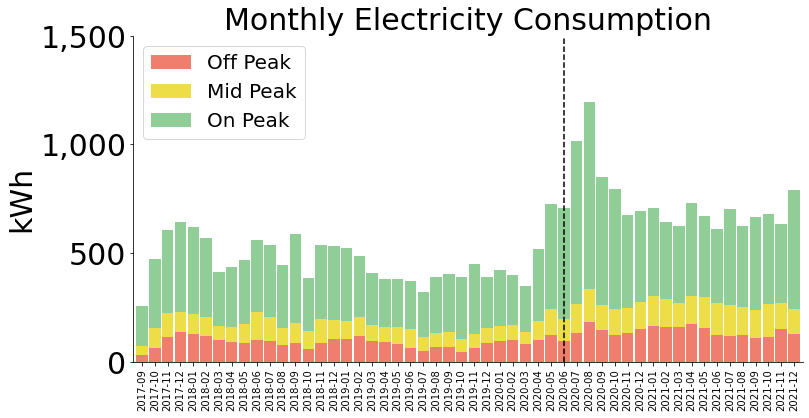

In [4]:
tco2 = pd.DataFrame()
tco2["Gas"] = gas["kgCO2"] / 1e3
tco2["Electricity"] = electricity["kgCO2"] / 1e3

cost = pd.DataFrame()
cost["Gas"] = gas["Gas Charges"]
cost["Electricity"] = electricity["Total"]

usage = pd.DataFrame()
usage["Gas"] = gas["Gas Consumption"] * GAS_KWH_PER_CUBIC_METER
usage["Electricity"] = electricity["Total Consumption"]

try:
    water_heater_install = [i for i, date in enumerate(tco2.index) if date.isoformat()[:7] == "2020-06"][0]
except AttributeError:
    water_heater_install = [i for i, date in enumerate(tco2.index) if date[:7] == "2020-06"][0]

plt.figure()
electricity[["On Peak Consumption", "Mid Peak Consumption", "Off Peak Consumption"]].plot.bar(
    stacked=True,
    width=bin_width,
    color=["#F07E6E", "#EDDD46", "#90CD97"],
    figsize=figsize,
)
plt.ylim((0, None))
plt.yticks(np.arange(0, 2000, step=500),
    ["{:,}".format(tic) for tic in np.arange(0, 2000, step=500)],
    fontsize=30,
);
plt.title("Monthly Electricity Consumption", fontsize=title_size)
plt.xlabel("")
plt.ylabel("kWh", fontsize=ylabel_size)
plt.legend(["Off Peak", "Mid Peak", "On Peak", "Total"], fontsize=20, loc="upper left")
os.makedirs("images", exist_ok=True)
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text()[:7] for label in labels]);
plt.plot([water_heater_install, water_heater_install], plt.ylim(), 'k--')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "monthly_electricity_consumption.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Gas consumption

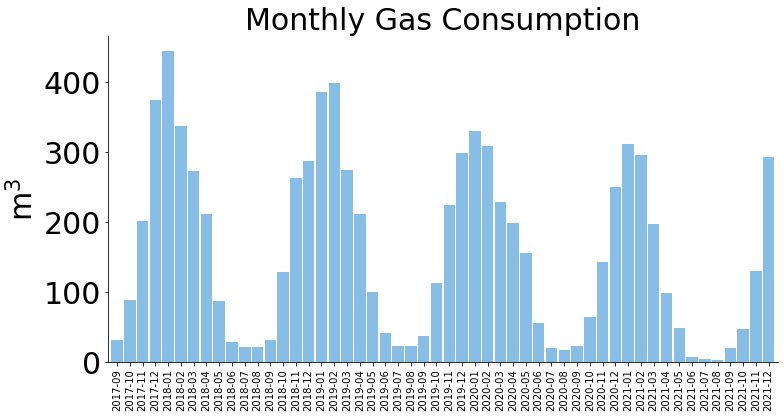

In [5]:
plt.figure()
gas["Gas Consumption"].plot.bar(
    width=bin_width,
    figsize=figsize,
)
plt.ylim((0, None))
plt.title("Monthly Gas Consumption", fontsize=title_size)
plt.ylabel("m$^3$", fontsize=ylabel_size)
os.makedirs("images", exist_ok=True)
plt.yticks(np.arange(0, 500, step=100),
    ["{:,}".format(tic) for tic in np.arange(0, 500, step=100)],
    fontsize=30,
);
plt.xlabel("")
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text()[:7] for label in labels])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "monthly_gas_consumption.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Energy consumption

<Figure size 432x288 with 0 Axes>

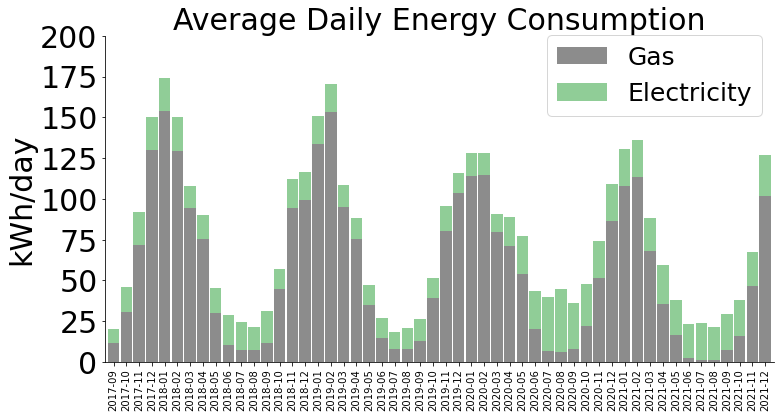

In [6]:
plt.figure()
daily = usage.copy()

try:
  days_in_month = daily.index.day
except:
  days_in_month = np.array([int(date[-2:]) for date in daily.index])

daily["Gas"] = daily["Gas"] / days_in_month
daily["Electricity"] = daily["Electricity"] / days_in_month
daily.plot.bar(
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    figsize=figsize,
    legend=None,
);
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs, labels=[label.get_text()[:7] for label in xlabels]);
plt.title("Average Daily Energy Consumption", fontsize=title_size)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1, 1.04), fontsize=25)
plt.ylabel("kWh/day", fontsize=ylabel_size)
plt.ylim((0, None))
ylocs, ylabels = plt.yticks()
plt.yticks(ylocs,
    [int(tic) for tic in ylocs],
    fontsize=30,
)
os.makedirs("images", exist_ok=True)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "daily_energy_consumption.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Monthly operating cost

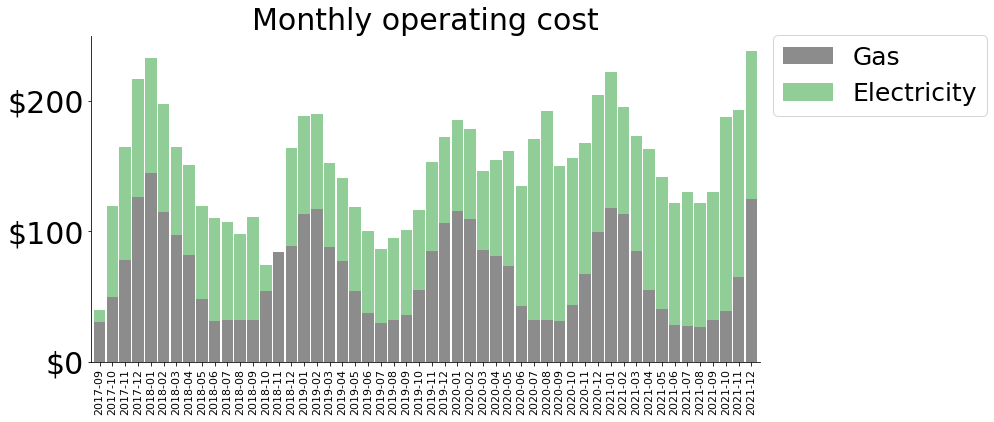

In [7]:
tco2 = pd.DataFrame()
tco2["Gas"] = gas["kgCO2"] / 1e3
tco2["Electricity"] = electricity["kgCO2"] / 1e3

cost = pd.DataFrame()
cost["Gas"] = gas["Gas Charges"]
cost["Electricity"] = electricity["Total"]

cost.plot.bar(
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    fontsize=11,
    figsize=figsize,
    legend=None,
)
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs, labels=[label.get_text()[:7] for label in xlabels]);
plt.title("Monthly operating cost", fontsize=title_size)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1, 1.04), fontsize=25)
plt.yticks(np.arange(0, 300, step=100),
    [f"${ tic }" for tic in np.arange(0, 300, step=100)],
    fontsize=30,
);
plt.ylim((0, 250))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "monthly_operating_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Monthly CO$_2$ emissions

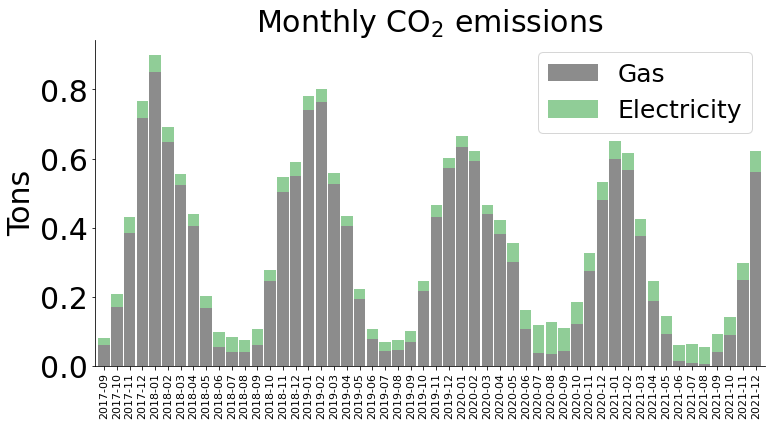

In [8]:
tco2.plot.bar(
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    fontsize=30,
    ylabel="tCO$_2$e",
    figsize=figsize,
)
plt.legend(
    #bbox_to_anchor=(1, 1.04),
    fontsize=25
)
plt.title("Monthly CO$_2$ emissions", fontsize=title_size)
plt.ylabel("Tons", fontsize=30)
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,
    labels=[label.get_text()[:7] for label in xlabels],
    fontsize=11,
);
plt.xlabel("")
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "monthly_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Average energy cost

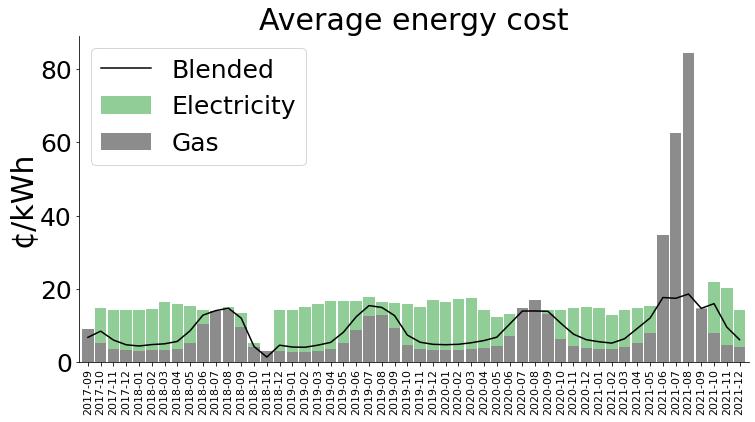

In [9]:
(100 * cost["Electricity"] / usage["Electricity"]).plot.bar(
    width=bin_width,
    fontsize=11,
    color=["#90cd97"],
    figsize=figsize,
    legend=None,
)
(100 * cost["Gas"] / usage["Gas"]).plot.bar(
    width=bin_width,
    color=["#8c8c8c"],
    fontsize=11,
    figsize=figsize,
)
plt.ylabel("¢/kWh", fontsize=30)
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs, labels=[label.get_text()[:7] for label in xlabels]);
ylocs, ylabels = plt.yticks()
plt.yticks(ylocs, [int(y) for y in ylocs], fontsize=25)
plt.plot(xlocs, 100 * (cost["Gas"] + cost["Electricity"]) / (usage["Gas"] + usage["Electricity"]), "k")
plt.title("Average energy cost", fontsize=title_size)
plt.xlabel("");
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.ylim([0, None])
plt.legend(
    ["Blended", "Electricity", "Gas"],
    #bbox_to_anchor=(1, 1.04),
    fontsize=25
)
plt.savefig(
    os.path.join("images", "average_energy_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Annual CO$_2$ emissions

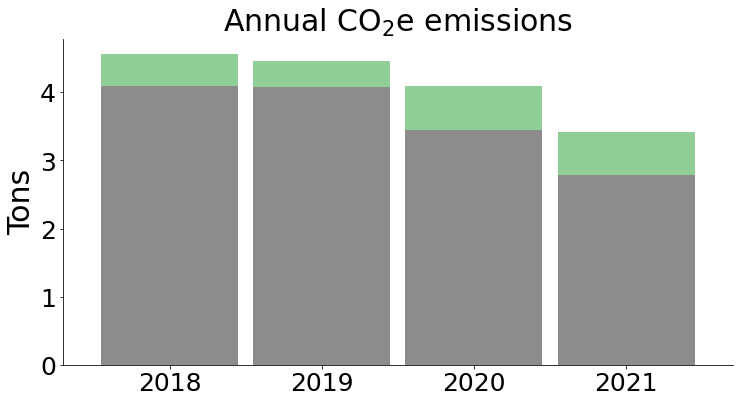

In [10]:
try:
    tco2["year"] = [date.year for date in tco2.index]
    cost["year"] = [date.year for date in cost.index]
except:
    tco2["year"] = [int(date[:4]) for date in tco2.index]
    cost["year"] = [int(date[:4]) for date in cost.index]
    
tco2[tco2["year"] > 2017].groupby("year").sum().plot.bar(
    stacked=True,
    fontsize=font_size,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    figsize=figsize,
    legend=None,
)
plt.title("Annual CO$_2$e emissions", fontsize=title_size)
plt.ylabel("Tons", fontsize=ylabel_size)
os.makedirs("images", exist_ok=True)
plt.xlabel("")
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=legend_size)
plt.xticks(rotation=0)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "annual_co2_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Annual operating costs

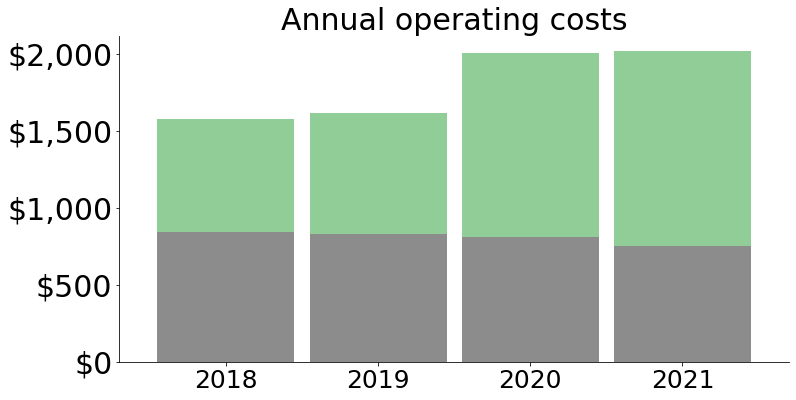

In [11]:
cost[cost["year"] > 2017].groupby("year").sum().plot.bar(
    stacked=True,
    fontsize=font_size,
    color=["#8c8c8c", "#90cd97"],
    width=bin_width,
    figsize=figsize,
    legend=None,
)
plt.title("Annual operating costs", fontsize=title_size)
os.makedirs("images", exist_ok=True)
plt.xlabel("")
#plt.legend(bbox_to_anchor=(1, 1.04), fontsize=legend_size)
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 2500, step=500),
    ["${:,}".format(tic) for tic in np.arange(0, 2500, step=500)],
    fontsize=30,
);
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "annual_operating_costs.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

# Comparing the 12 months before and after installing the HW heater

In [12]:
water_heater_install_date = "2020-06-16"
after_idx = [i for i, date in enumerate(tco2.index) if arrow.get(date).naive > arrow.get(water_heater_install_date).naive]
before_idx = [i for i, date in enumerate(tco2.index) if arrow.get(date).naive < arrow.get(water_heater_install_date).naive]

In [13]:
comparison = pd.DataFrame()
comparison["tco2_Gas"] = tco2["Gas"].iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["tco2_Electricity"] = tco2["Electricity"].iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["tco2_Total"] = comparison["tco2_Gas"] + comparison["tco2_Electricity"]
comparison["cost_Gas"] = cost["Gas"].iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["cost_Electricity"] = cost["Electricity"].iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["cost_Total"] = comparison["cost_Gas"] + comparison["cost_Electricity"]
comparison["usage_kwh_Gas"] = (gas["Gas Consumption"] * GAS_KWH_PER_CUBIC_METER).iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["usage_kwh_Electricity"] = electricity["Total Consumption"].iloc[before_idx[-12:] + after_idx[:12]].copy()
comparison["usage_kwh_Total"] = comparison["usage_kwh_Gas"] + comparison["usage_kwh_Electricity"]
comparison["Average_rate_Gas"] = comparison["cost_Gas"] / comparison["usage_kwh_Gas"]
comparison["Average_rate_Electricity"] = comparison["cost_Electricity"] / comparison["usage_kwh_Electricity"]
comparison["Average_rate_Blended"] = comparison["cost_Total"] / comparison["usage_kwh_Total"]
comparison["Period"] = ["before"]*12 + ["after"]*12
comparison.tail()

,tco2_Gas,tco2_Electricity,tco2_Total,cost_Gas,cost_Electricity,cost_Total,usage_kwh_Gas,usage_kwh_Electricity,usage_kwh_Total,Average_rate_Gas,Average_rate_Electricity,Average_rate_Blended,Period
Date,,,,,,,,,,,,,
2021-01-31,0.597326,0.054458,0.651784,117.850000,104.421724,222.271724,3347.008478,707.251724,4054.260202,0.035211,0.147644,0.054824,after
2021-02-28,0.566027,0.049591,0.615618,113.085000,81.990000,195.075000,3171.629699,644.039259,3815.668958,0.035655,0.127306,0.051125,after
2021-03-31,0.377104,0.048041,0.425145,85.033226,87.777647,172.810873,2113.034884,623.912941,2736.947825,0.040242,0.140689,0.063140,after
2021-04-30,0.188676,0.056138,0.244813,55.290000,108.196667,163.486667,1057.209900,729.061333,1786.271233,0.052298,0.148405,0.091524,after
2021-05-31,0.091764,0.051550,0.143313,40.144375,101.753214,141.897589,514.182353,669.476071,1183.658424,0.078074,0.151989,0.119881,after


## CO$_2$ reduced by 0.6t (-13%)

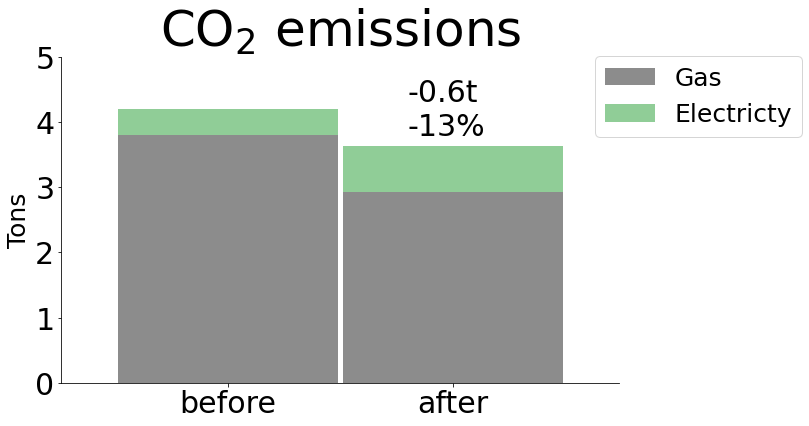

In [14]:
comparison.groupby("Period").sum().sort_index(ascending=False)[["tco2_Gas", "tco2_Electricity"]].plot.bar(
    width=.98,
    fontsize=30,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    figsize=(10, 6),
);
plt.xticks(rotation=0)
plt.xlabel("")
plt.title("CO$_2$ emissions", fontsize=50)
plt.yticks(range(6))
plt.ylabel("Tons", fontsize=25)
delta = np.diff(comparison.groupby("Period")["tco2_Total"].sum().sort_index(ascending=False))[0]
delta_pct = 100 * delta / comparison["tco2_Total"][:12].sum()
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 3.8, "%s%.01ft\n%s%.0f%%" % (sign, delta, sign, delta_pct),
    fontsize=30,
)
plt.legend(labels=["Gas", "Electricty"],
    bbox_to_anchor=(1.35, 1.04), fontsize=25
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_emissions.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Operating cost up by $422 (+26%)

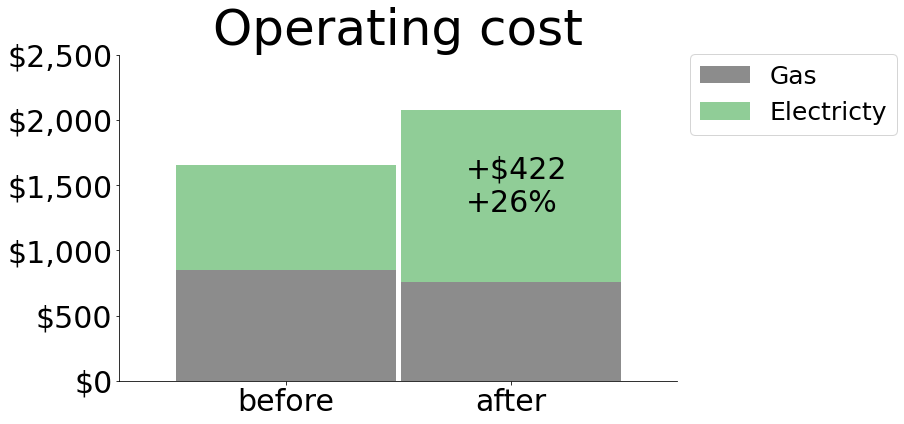

In [15]:
comparison.groupby("Period").sum().sort_index(ascending=False)[["cost_Gas", "cost_Electricity"]].plot.bar(
    width=.98,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.xticks(rotation=0)
plt.legend(labels=["Gas", "Electricty"],
    bbox_to_anchor=(1, 1.04), fontsize=25
)
plt.title("Operating cost", fontsize=50)
plt.xlabel("")
plt.yticks(np.arange(0, 3000, step=500),
    ["${:,}".format(tic) for tic in np.arange(0, 3000, step=500)],
    fontsize=30,
);
delta = np.diff(comparison.groupby("Period")["cost_Total"].sum().sort_index(ascending=False))[0]
delta_pct = 100 * delta / comparison["cost_Total"][:12].sum()
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 1300, "%s\$%.0f\n%s%.0f%%" % (sign, delta, sign, delta_pct),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_operating_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Normalized operating cost up by $293 (+13%)

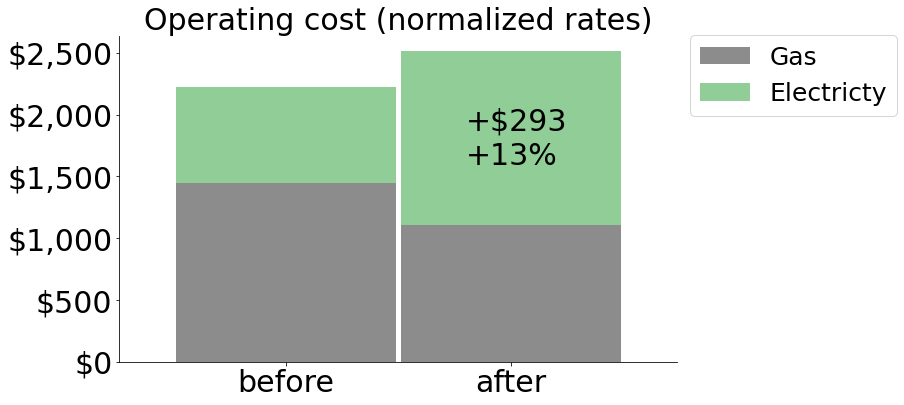

In [16]:
fixed_rate_comparison = comparison.copy()
fixed_rate_comparison["cost_Gas"] = fixed_rate_comparison["usage_kwh_Gas"] * fixed_rate_comparison["Average_rate_Gas"].mean()
fixed_rate_comparison["cost_Electricity"] = fixed_rate_comparison["usage_kwh_Electricity"] * fixed_rate_comparison["Average_rate_Electricity"].mean()
fixed_rate_comparison["cost_Total"] = fixed_rate_comparison["cost_Gas"] + fixed_rate_comparison["cost_Electricity"]
fixed_rate_comparison.groupby("Period").sum().sort_index(ascending=False)[["cost_Gas", "cost_Electricity"]].plot.bar(
    width=.98,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.xticks(rotation=0)
plt.legend(labels=["Gas", "Electricty"],
    bbox_to_anchor=(1, 1.04), fontsize=25
)
plt.title("Operating cost (normalized rates)", fontsize=30)
plt.xlabel("")
plt.yticks(np.arange(0, 3000, step=500),
    ["${:,}".format(tic) for tic in np.arange(0, 3000, step=500)],
    fontsize=30,
);
delta = np.diff(fixed_rate_comparison.groupby("Period")["cost_Total"].sum().sort_index(ascending=False))[0]
delta_pct = 100 * delta / fixed_rate_comparison["cost_Total"][:12].sum()
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 1600, "%s\$%.0f\n%s%.0f%%" % (sign, delta, sign, delta_pct),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_operating_cost.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Daily energy use down by 2.1kWh (-3%)

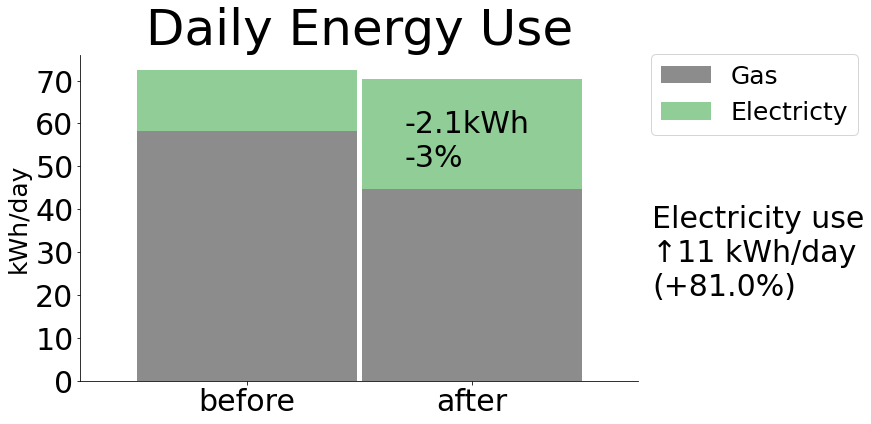

In [17]:
(comparison.groupby("Period").sum().sort_index(ascending=False)[["usage_kwh_Gas", "usage_kwh_Electricity"]] / 365).plot.bar(
    width=.98,
    stacked=True,
    color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.xticks(rotation=0)
plt.legend(labels=["Gas", "Electricty"],
    bbox_to_anchor=(1, 1.04), fontsize=25
)
plt.title("Daily Energy Use", fontsize=50)
plt.xlabel("")
plt.ylabel("kWh/day", fontsize=25)
# plt.yticks(np.arange(0, 2500, step=500),
#     ["${:,}".format(tic) for tic in np.arange(0, 2500, step=500)],
#     fontsize=30,
# );
delta = np.diff(comparison.groupby("Period").sum()["usage_kwh_Total"].sort_index(ascending=False))[0]
delta_pct = 100 * delta / comparison.usage_kwh_Total[:12].sum()
sign = ["+" if delta > 0 else ""][0]
plt.text(0.7, 50, "%s%.1fkWh\n%s%.0f%%" % (sign, delta / 365, sign, delta_pct),
    fontsize=30,
)
plt.yticks(np.arange(0, 80, step=10),
    ["{:,}".format(tic) for tic in np.arange(0, 80, step=10)],
    fontsize=30,
);
delta = np.diff(comparison.groupby("Period").sum().sort_index(ascending=False)["usage_kwh_Electricity"])[0]
delta_pct = 100 * delta / comparison.groupby("Period").sum().sort_index(ascending=False)["usage_kwh_Electricity"][0]
sign = ["+" if delta > 0 else ""][0]
plt.text(1.8, 20, "Electricity use\n↑%.0f kWh/day\n(%s%.1f%%)" % (delta / 365, sign, delta_pct),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_usage.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

What units/timescale makes sense here? Daily seems to strike the right balance of immediate, short-term feedback that is meaningful (averages out hourly "noise").

## Blended rate up by 1.2¢ (+14%)

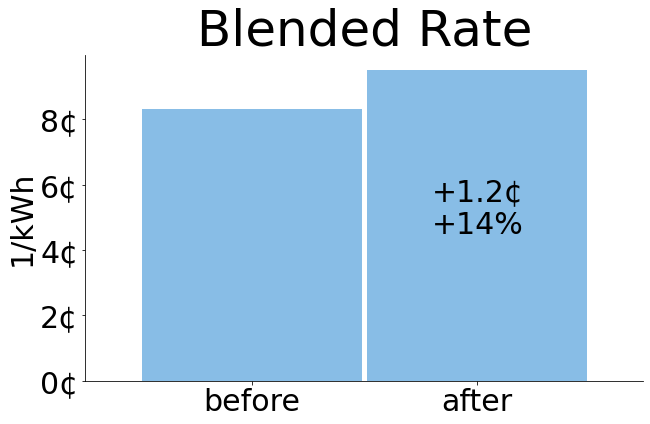

In [18]:
(100 * (comparison.groupby("Period").mean().sort_index(ascending=False)["Average_rate_Blended"])).plot.bar(
    width=.98,
    stacked=True,
    #color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.ylabel("1/kWh", fontsize=30)
plt.xticks(rotation=0)
plt.title("Blended Rate", fontsize=50)
plt.xlabel("")
plt.yticks(np.arange(0, 10, step=2),
    ["{:,}¢".format(tic) for tic in np.arange(0, 10, step=2)],
    fontsize=30,
);
delta = 100 * np.diff(comparison.groupby("Period")["Average_rate_Blended"].mean().sort_index(ascending=False))[0]
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 4.5, "%s%.1f¢\n%s%.0f%%" % (sign, delta, sign,
    (delta / comparison.iloc[:12]['Average_rate_Blended'].mean())),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_usage.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

The blended rate went up because we shifted some of our energy use (HW heating) from lower priced gas to higher priced electricity and because the gas rate went up by 25%.

## Gas rate up by 1.5¢ (+25%)

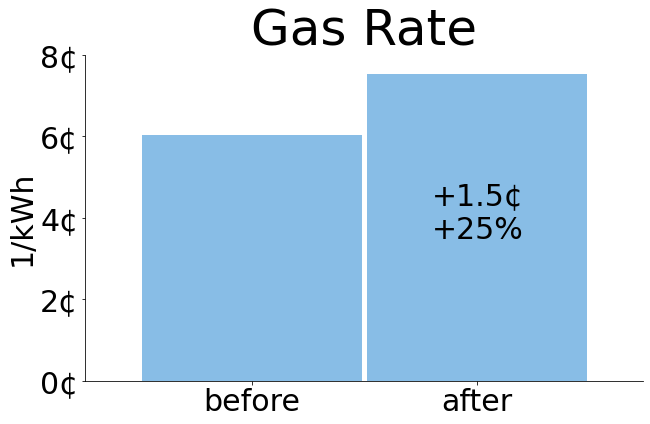

In [19]:
(100 * (comparison.groupby("Period").mean().sort_index(ascending=False)["Average_rate_Gas"])).plot.bar(
    width=.98,
    stacked=True,
    #color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.ylabel("1/kWh", fontsize=30)
plt.xticks(rotation=0)
plt.title("Gas Rate", fontsize=50)
plt.xlabel("")
plt.yticks(np.arange(0, 10, step=2),
    ["{:,}¢".format(tic) for tic in np.arange(0, 10, step=2)],
    fontsize=30,
);
delta = 100 * np.diff(comparison.groupby("Period")["Average_rate_Gas"].mean().sort_index(ascending=False))[0]
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 3.5, "%s%.1f¢\n%s%.0f%%" % (sign, delta, sign,
    (delta / comparison.iloc[:12]['Average_rate_Gas'].mean())),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_gas_rate.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Electricity rate down by 1.8¢ (-11%)

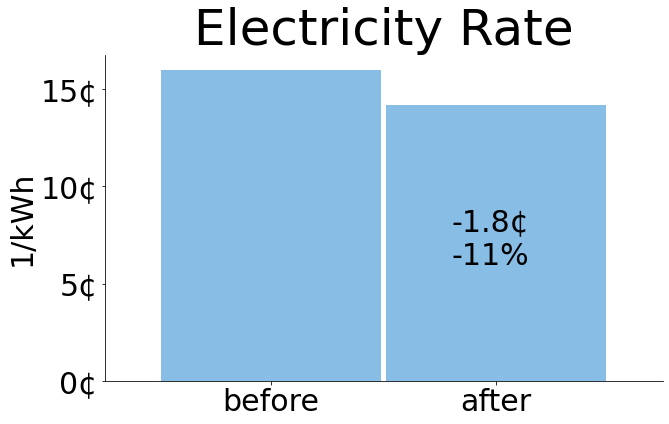

In [20]:
(100 * (comparison.groupby("Period").mean().sort_index(ascending=False)["Average_rate_Electricity"])).plot.bar(
    width=.98,
    stacked=True,
    #color=["#8c8c8c", "#90cd97"],
    fontsize=30,
    figsize=(10, 6),
    legend=None,
)
plt.ylabel("1/kWh", fontsize=30)
plt.xticks(rotation=0)
plt.title("Electricity Rate", fontsize=50)
plt.xlabel("")
#ylocs, ylabels = plt.yticks()
ylocs = range(0,20,5)
plt.yticks(ylocs,
    ["%d¢" % tic for tic in ylocs],
    fontsize=30,
);
delta = 100 * np.diff(comparison.groupby("Period")["Average_rate_Electricity"].mean().sort_index(ascending=False))[0]
sign = ["+" if delta > 0 else ""][0]
plt.text(0.8, 6, "%s%.1f¢\n%s%.0f%%" % (sign, delta, sign,
    (delta / comparison.iloc[:12]['Average_rate_Electricity'].mean())),
    fontsize=30,
)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig(
    os.path.join("images", "compare_electricity_rate.svg"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

# Cost of energy

<div class="alert alert-block alert-success">
When trying to predict future costs, a major component will be the cost of energy (best represented by the Levelized Cost of Energy; LCOE). LCOE solar in various countries is
between <b>$20-50/MWh (2-5¢/kWh)</b> in 2021 (note that this is utility scale;  rooftop residential numbers  will be slightly higher and need to account for storage or grid backup).
In the near future (maybe even now?), the LCOE is likely to be cheaper for rooftop generated solar versus natural gas, making heat pumps much more attractive.
</div>

[![LCOE_New_Solar](https://github.com/ryanfobel/utility-bill-scraper/blob/main/notebooks/features/images/LCOE_New_Solar.jpg?raw=1)](https://www.renewableenergyworld.com/solar/report-its-now-cheaper-to-build-new-solar-than-to-run-existing-coal-plants-in-china-india-and-most-of-europe)

This seems to be inline with the US gov SunShot goals.

[![LCOE-bar-Chart-2030-Goals](https://github.com/ryanfobel/utility-bill-scraper/blob/main/notebooks/features/images/LCOE-bar-Chart-2030-Goals-2017.png?raw=1)](https://www.energy.gov/eere/solar/sunshot-2030)